In [1]:
import numpy as np
from numpy import linalg as la
from numpy import *
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split


print (torch.__version__, torch.cuda.is_available())
print(torch.version.cuda)
print (torch.cuda.get_device_name())


# device= 'cpu'
device= 'cuda'

2.3.1 True
11.8
NVIDIA GeForce RTX 3070 Ti


OU process(1D):
$$dX_t = \theta(\mu-X_t)dt + \sigma dW_t$$

In [2]:
def ou_process_1d(theta=1, mu=0, sigma=1, X0=0, n_steps=10000, n_eval=200, h=1e-5):
    """
    Simulates the Ornstein-Uhlenbeck process.
    
    Parameters:
    - theta: rate of mean reversion
    - mu: long-term mean of the process
    - sigma: volatility
    - X0: initial value
    - n_steps: number of steps in each evaluation
    - n_eval: number of evaluations
    - h: Integration step size
    
    Returns:
    - A numpy array containing the simulated values at each evaluation
    """
    X_eval = np.zeros(n_eval)
    X = X0
    
    for i in range(n_eval):
        for _ in range(n_steps):
            dW = np.sqrt(h) * np.random.randn()
            X = X + theta * (mu - X) * h + sigma * dW
        X_eval[i] = X
    
    return X_eval

In [3]:
## Setup the parameters
theta = 1
mu = 0
sigma = 0.1

(200,)


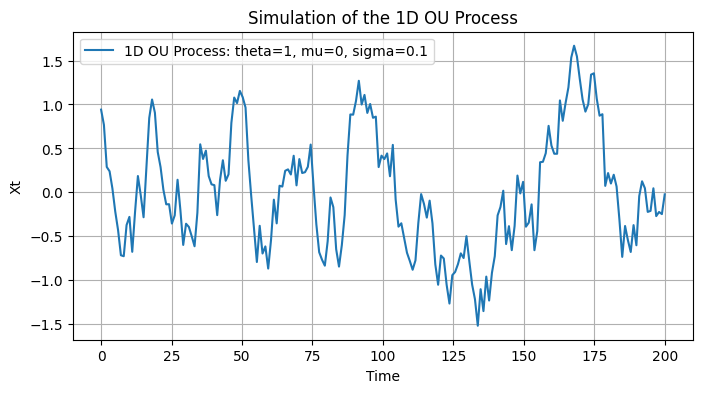

In [4]:
## Simulate a single trajectory
n_steps = 10000
h = 1e-5
n_eval = 200
lag_time = n_steps * h

X0 = np.random.uniform(-2, 2) # initial point
X_eval = ou_process_1d(X0=X0, n_steps=n_steps, n_eval=n_eval, h=h)
print(X_eval.shape)
# Plot the simulated path

times = np.linspace(0, n_eval, len(X_eval)) # Creating the time array for plotting

plt.figure(figsize=(8, 4))
plt.plot(times, X_eval, label=f"1D OU Process: theta={theta}, mu={mu}, sigma={sigma}")
plt.title("Simulation of the 1D OU Process")
plt.xlabel("Time")
plt.ylabel("Xt")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Generate m initial points from the domain space [-2, 2]
m = 10
n_eval = 300
n_steps = 10000
h = 1e-5
X0_values = np.linspace(-2, 2, m)

# Initialize the data_matrix
data_matrix = np.zeros((m, n_eval+1, 1))

# Simulate trajectories for each initial point and store them in the data_matrix
for i, X0 in tqdm(enumerate(X0_values), total=m, desc="Simulating trajectories"):
    X_eval = np.concatenate(([X0], ou_process_1d(X0=X0, n_steps=n_steps, n_eval=n_eval, h=h)))
    data_matrix[i, :, 0] = X_eval

# Print the shape of data_matrix
print("Shape of data_matrix:", data_matrix.shape)

Simulating trajectories: 100%|██████████| 10/10 [00:40<00:00,  4.05s/it]

Shape of data_matrix: (10, 301, 1)


In [6]:
## Save the data to local folder
# Create a folder to store the data (if it doesn't exist)
folder_path = "data"
os.makedirs(folder_path, exist_ok=True)

# Save the data_matrix to a file
file_path = os.path.join(folder_path, "ou_process_1d.npy")
np.save(file_path, data_matrix)

In [7]:
## load the data from local folder
# Load the data_matrix from the file
folder_path = "data"
file_path = os.path.join(folder_path, "ou_process_1d.npy")
data_matrix = np.load(file_path)

In [8]:
# Extract data_X and data_Y from the data matrix
data_X = data_matrix[:, :-1, :]
data_Y = data_matrix[:, 1:, :]
print(f"Shape of data_X: {data_X.shape}")
print(f"Shape of data_Y: {data_Y.shape}")

# Reshape data_X and data_Y into a single column
X = data_X.reshape(-1, data_X.shape[2])  # 2D features
Y = data_Y.reshape(-1, data_X.shape[2])  # 2D targets
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

Shape of data_X: (10, 300, 1)
Shape of data_Y: (10, 300, 1)
Shape of X: (3000, 1)
Shape of Y: (3000, 1)


In [9]:
# Separate data into two parts: train and validation
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all)]
data_x_valid = X[int(0.7*len_all)+1:]

data_y_train = Y[:int(0.7*len_all)]
data_y_valid = Y[int(0.7*len_all)+1:]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

print(data_x_train.shape)

(2100, 1)


In [10]:
checkpoint_file= 'ou1d_example_ckpt002.torch'

from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch

basis_function = KoopmanNNTorch(input_size=1, layer_sizes=[20, 20], n_psi_train=18).to(device)

solver = KoopmanSolverTorch(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                       reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn_ou_001.torch', 
                generator_batch_size= 4, fnn_batch_size= 32, delta_t= lag_time)

data_x_train_tensor = torch.DoubleTensor(data_x_train).to (device)#, requieres_grad= True)#, dtype=tf.float64)
data_y_train_tensor = torch.DoubleTensor(data_y_train).to (device)#, requires_grad= True)#, dtype=tf.float64)

In [11]:
# # Compute the drift and diffusion terms
# #b_Xt, a_Xt = solver.compute_var_coefficients(data_x_train_tensor)
# b_Xt, a_Xt = solver.compute_neural_a_b(data_x_train_tensor)
# print("\nDrift term (b_Xt):")
# print(b_Xt.detach().shape)
# print(b_Xt.detach().cpu().numpy())
# print("\nDiffusion term (a_Xt):")
# print(a_Xt.shape)
# print(a_Xt.detach().cpu().numpy())

In [12]:
# # Compute L_Psi
# L_Psi = solver.compute_generator_L(data_x_train_tensor, b_Xt, a_Xt)

# print("\nL_Psi:")
# print(L_Psi.shape)
# print(L_Psi.detach().cpu().numpy())

In [13]:
solver.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=16,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

Epoch: 1 	Training Loss: 0.595589 val loss: 0.600729
saving, val loss enhanced: 0.6007294963550579 10000
Epoch: 2 	Training Loss: 0.573919 val loss: 0.568018
saving, val loss enhanced: 0.5680175950326617 0.6007294963550579
Epoch: 3 	Training Loss: 0.547234 val loss: 0.539992
saving, val loss enhanced: 0.5399918500171679 0.5680175950326617
Epoch: 4 	Training Loss: 0.525072 val loss: 0.514503
saving, val loss enhanced: 0.5145032122554436 0.5399918500171679
Epoch: 5 	Training Loss: 0.500082 val loss: 0.484044
saving, val loss enhanced: 0.48404363153159763 0.5145032122554436
Epoch: 6 	Training Loss: 0.476771 val loss: 0.467953
saving, val loss enhanced: 0.4679534094866722 0.48404363153159763
Epoch: 7 	Training Loss: 0.459155 val loss: 0.446843
saving, val loss enhanced: 0.4468428076083082 0.4679534094866722
Epoch: 8 	Training Loss: 0.441507 val loss: 0.427210
saving, val loss enhanced: 0.4272099223099758 0.4468428076083082
Epoch: 9 	Training Loss: 0.416367 val loss: 0.405545
saving, val lo

Computing dPsi_X: 100%|██████████| 41980/41980 [00:10<00:00, 3843.37iteration/s]


dPsi_X shape:  torch.Size([2099, 20])
psi_x shape:  torch.Size([2099, 20])
psi_x_inv shape:  torch.Size([20, 2099])
cuda:0
cuda:0
Outer Epoch 1/16


Computing dPsi_X: 100%|██████████| 41980/41980 [00:13<00:00, 3059.13iteration/s]


dPsi_X shape:  torch.Size([2099, 20])
psi_x shape:  torch.Size([2099, 20])
psi_x_inv shape:  torch.Size([20, 2099])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 86319027079490.953125 val loss: 97952250538884.687500
saving, val loss enhanced: 97952250538884.69 1000000000000000.0
Epoch: 2 	Training Loss: 85974477592289.203125 val loss: 97566442100350.359375
saving, val loss enhanced: 97566442100350.36 97952250538884.69
Epoch: 3 	Training Loss: 85634925474562.171875 val loss: 97182409935792.734375
saving, val loss enhanced: 97182409935792.73 97566442100350.36
Epoch: 4 	Training Loss: 85296709769676.828125 val loss: 96799597317244.187500
saving, val loss enhanced: 96799597317244.19 97182409935792.73
Epoch: 5 	Training Loss: 84959560753932.796875 val loss: 96417978116313.218750
saving, val loss enhanced: 96417978116313.22 96799597317244.19
Epoch: 6 	Training Loss: 84623491474852.406250 val loss: 96037616195168.625000
saving, val loss enhanced: 96037616195168.62 96417978116313.22
Epoch: 7 	Trainin

Computing dPsi_X: 100%|██████████| 41980/41980 [00:10<00:00, 3939.35iteration/s]


dPsi_X shape:  torch.Size([2099, 20])
psi_x shape:  torch.Size([2099, 20])
psi_x_inv shape:  torch.Size([20, 2099])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 173240141747.968201 val loss: 198409453845.380737
saving, val loss enhanced: 198409453845.38074 65332753433347.46
Epoch: 2 	Training Loss: 173175779949.641144 val loss: 198369836108.523315
saving, val loss enhanced: 198369836108.52332 198409453845.38074
Epoch: 3 	Training Loss: 173150318856.480316 val loss: 198353985131.753448
saving, val loss enhanced: 198353985131.75345 198369836108.52332
Epoch: 4 	Training Loss: 173140042402.648621 val loss: 198347409185.482819
saving, val loss enhanced: 198347409185.48282 198353985131.75345
Epoch: 5 	Training Loss: 173135690913.636841 val loss: 198344450769.343231
saving, val loss enhanced: 198344450769.34323 198347409185.48282
Epoch: 6 	Training Loss: 173133649608.215179 val loss: 198342901450.632507
saving, val loss enhanced: 198342901450.6325 198344450769.34323
Epoch: 7 	Training Loss: 1731325

Computing dPsi_X: 100%|██████████| 41980/41980 [00:10<00:00, 3905.58iteration/s]


dPsi_X shape:  torch.Size([2099, 20])
psi_x shape:  torch.Size([2099, 20])
psi_x_inv shape:  torch.Size([20, 2099])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 159746168965.597839 val loss: 183017437754.179108
saving, val loss enhanced: 183017437754.1791 198259005411.06842
Epoch: 2 	Training Loss: 159745314038.164062 val loss: 183016474882.036591
saving, val loss enhanced: 183016474882.0366 183017437754.1791
Epoch: 3 	Training Loss: 159744477851.570831 val loss: 183015521263.535217
saving, val loss enhanced: 183015521263.53522 183016474882.0366
Epoch: 4 	Training Loss: 159743646266.913330 val loss: 183014568150.715424
saving, val loss enhanced: 183014568150.71542 183015521263.53522
Epoch: 5 	Training Loss: 159742813767.132812 val loss: 183013612124.928986
saving, val loss enhanced: 183013612124.929 183014568150.71542
Epoch: 6 	Training Loss: 159741978193.468475 val loss: 183012651843.304260
saving, val loss enhanced: 183012651843.30426 183013612124.929
Epoch: 7 	Training Loss: 159741138695.

Computing dPsi_X: 100%|██████████| 41980/41980 [00:10<00:00, 3870.42iteration/s]


dPsi_X shape:  torch.Size([2099, 20])
psi_x shape:  torch.Size([2099, 20])
psi_x_inv shape:  torch.Size([20, 2099])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 190581320696.303711 val loss: 218332557087.224060
Epoch: 2 	Training Loss: 190579455076.728516 val loss: 218330329698.600006
Epoch: 3 	Training Loss: 190577483570.566711 val loss: 218328031685.301178
Epoch: 4 	Training Loss: 190575464874.317444 val loss: 218325699322.040161
Epoch: 5 	Training Loss: 190573421813.573547 val loss: 218323346702.035950
Epoch: 6 	Training Loss: 190571363249.449463 val loss: 218320979283.258606
Epoch: 7 	Training Loss: 190569292606.665771 val loss: 218318599161.908783
Epoch: 8 	Training Loss: 190567211193.480804 val loss: 218316207125.345398
Epoch: 9 	Training Loss: 190565119494.116333 val loss: 218313803451.272827
Epoch: 10 	Training Loss: 190563017671.886322 val loss: 218311388218.856842
Epoch: 11 	Training Loss: 190560905765.060089 val loss: 218308961429.837280
Epoch: 12 	Training Loss: 190558783763.1090

Computing dPsi_X: 100%|██████████| 41980/41980 [00:11<00:00, 3641.28iteration/s]


dPsi_X shape:  torch.Size([2099, 20])
psi_x shape:  torch.Size([2099, 20])
psi_x_inv shape:  torch.Size([20, 2099])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 269131975012.565430 val loss: 308284224371.658813
Epoch: 2 	Training Loss: 269125759409.453857 val loss: 308276539385.766296
Epoch: 3 	Training Loss: 269118880321.532013 val loss: 308268426905.765137
Epoch: 4 	Training Loss: 269111722719.110046 val loss: 308260124759.591370
Epoch: 5 	Training Loss: 269104436352.637970 val loss: 308251725415.049011
Epoch: 6 	Training Loss: 269097079421.327850 val loss: 308243264763.597717
Epoch: 7 	Training Loss: 269089674491.216309 val loss: 308234756676.164429
Epoch: 8 	Training Loss: 269082230259.174103 val loss: 308226206452.655945
Epoch: 9 	Training Loss: 269074750023.696503 val loss: 308217616056.645386
Epoch: 10 	Training Loss: 269067234981.820892 val loss: 308208986152.761414
Epoch: 11 	Training Loss: 269059685512.316437 val loss: 308200316899.656860
Epoch: 12 	Training Loss: 269052101675.1117

Computing dPsi_X: 100%|██████████| 41980/41980 [00:10<00:00, 4099.53iteration/s]


dPsi_X shape:  torch.Size([2099, 20])
psi_x shape:  torch.Size([2099, 20])
psi_x_inv shape:  torch.Size([20, 2099])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 542406244323.730957 val loss: 621139542929.610352
Epoch: 2 	Training Loss: 542360875041.751526 val loss: 621079821457.991577
Epoch: 3 	Training Loss: 542306393367.729309 val loss: 621014342663.251953
Epoch: 4 	Training Loss: 542248212855.631409 val loss: 620946448173.021973
Epoch: 5 	Training Loss: 542188439537.116577 val loss: 620877437670.382202
Epoch: 6 	Training Loss: 542127892370.103699 val loss: 620807816261.973511
Epoch: 7 	Training Loss: 542066889479.333801 val loss: 620737779866.565186
Epoch: 8 	Training Loss: 542005554104.002136 val loss: 620667404090.689819
Epoch: 9 	Training Loss: 541943933648.490112 val loss: 620596717723.772583
Epoch: 10 	Training Loss: 541882046007.211670 val loss: 620525731336.368774
Epoch: 11 	Training Loss: 541819897590.402405 val loss: 620454448408.206543
Epoch: 12 	Training Loss: 541757490338.2443

Computing dPsi_X: 100%|██████████| 41980/41980 [00:11<00:00, 3712.73iteration/s]


dPsi_X shape:  torch.Size([2099, 20])
psi_x shape:  torch.Size([2099, 20])
psi_x_inv shape:  torch.Size([20, 2099])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1744802224737.298096 val loss: 1996619854016.253662
Epoch: 2 	Training Loss: 1743874759203.807373 val loss: 1995330144439.675537
Epoch: 3 	Training Loss: 1742680005494.282715 val loss: 1993875411341.050537
Epoch: 4 	Training Loss: 1741380873357.509277 val loss: 1992355866901.880371
Epoch: 5 	Training Loss: 1740040542213.531006 val loss: 1990810351909.600342
Epoch: 6 	Training Loss: 1738683488521.796631 val loss: 1989253893256.278564
Epoch: 7 	Training Loss: 1737319171493.313965 val loss: 1987692278759.580566
Epoch: 8 	Training Loss: 1735951224528.365234 val loss: 1986127712820.361572
Epoch: 9 	Training Loss: 1734581021858.990967 val loss: 1984561010994.808594
Epoch: 10 	Training Loss: 1733209062496.375244 val loss: 1982992451500.486816
Epoch: 11 	Training Loss: 1731835507185.761230 val loss: 1981422105542.842529
Epoch: 12 	Training L

Computing dPsi_X: 100%|██████████| 41980/41980 [00:10<00:00, 4044.15iteration/s]


dPsi_X shape:  torch.Size([2099, 20])
psi_x shape:  torch.Size([2099, 20])
psi_x_inv shape:  torch.Size([20, 2099])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 1213622584570.199951 val loss: 1389163187138.657959
Epoch: 2 	Training Loss: 1213135444789.234863 val loss: 1388617616115.911377
Epoch: 3 	Training Loss: 1212660159191.970947 val loss: 1388078503271.619873
Epoch: 4 	Training Loss: 1212188555127.576904 val loss: 1387540828112.734619
Epoch: 5 	Training Loss: 1211717439595.273682 val loss: 1387002628972.957520
Epoch: 6 	Training Loss: 1211245564531.147217 val loss: 1386463137944.818115
Epoch: 7 	Training Loss: 1210772440737.339844 val loss: 1385922052753.125488
Epoch: 8 	Training Loss: 1210297874989.496338 val loss: 1385379252704.982422
Epoch: 9 	Training Loss: 1209821789479.070312 val loss: 1384834687909.741699
Epoch: 10 	Training Loss: 1209344151398.377441 val loss: 1384288336078.994873
Epoch: 11 	Training Loss: 1208864945481.750000 val loss: 1383740185680.792480
Epoch: 12 	Training L

Computing dPsi_X: 100%|██████████| 41980/41980 [00:10<00:00, 3886.34iteration/s]


dPsi_X shape:  torch.Size([2099, 20])
psi_x shape:  torch.Size([2099, 20])
psi_x_inv shape:  torch.Size([20, 2099])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 789012133548.914795 val loss: 904194204285.723389
Epoch: 2 	Training Loss: 788844839647.830444 val loss: 904018625164.503662
Epoch: 3 	Training Loss: 788695734196.713013 val loss: 903853847107.569092
Epoch: 4 	Training Loss: 788553346783.138550 val loss: 903692858990.132080
Epoch: 5 	Training Loss: 788413212587.489014 val loss: 903532930778.868164
Epoch: 6 	Training Loss: 788273592643.360229 val loss: 903372998358.379150
Epoch: 7 	Training Loss: 788133808732.302490 val loss: 903212645915.543701
Epoch: 8 	Training Loss: 787993595436.040894 val loss: 903051709930.780884
Epoch: 9 	Training Loss: 787852847981.414551 val loss: 902890125064.527344
Epoch: 10 	Training Loss: 787711524109.189941 val loss: 902727864180.514771
Epoch: 11 	Training Loss: 787569605883.937622 val loss: 902564915004.357178
Epoch: 12 	Training Loss: 787427084831.3571

Computing dPsi_X: 100%|██████████| 41980/41980 [00:10<00:00, 3952.42iteration/s]


dPsi_X shape:  torch.Size([2099, 20])
psi_x shape:  torch.Size([2099, 20])
psi_x_inv shape:  torch.Size([20, 2099])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 2857796346490.159668 val loss: 3274699168989.037598
Epoch: 2 	Training Loss: 2856615986931.034668 val loss: 3273092388687.870605
Epoch: 3 	Training Loss: 2855138173594.419434 val loss: 3271301909895.783691
Epoch: 4 	Training Loss: 2853544330217.518066 val loss: 3269439383519.258789
Epoch: 5 	Training Loss: 2851904787748.710449 val loss: 3267548070173.078613
Epoch: 6 	Training Loss: 2850246786535.185547 val loss: 3265644706992.506348
Epoch: 7 	Training Loss: 2848580856131.773438 val loss: 3263735745931.328125
Epoch: 8 	Training Loss: 2846911046378.689941 val loss: 3261823651218.572754
Epoch: 9 	Training Loss: 2845238895073.229980 val loss: 3259909341515.646973
Epoch: 10 	Training Loss: 2843564966607.895508 val loss: 3257993136962.781250
Epoch: 11 	Training Loss: 2841889448626.240234 val loss: 3256075126415.340332
Epoch: 12 	Training L

Computing dPsi_X: 100%|██████████| 41980/41980 [00:11<00:00, 3711.43iteration/s]


dPsi_X shape:  torch.Size([2099, 20])
psi_x shape:  torch.Size([2099, 20])
psi_x_inv shape:  torch.Size([20, 2099])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 2087321268648.750244 val loss: 2394248151089.367676
Epoch: 2 	Training Loss: 2084896324341.012207 val loss: 2390433705514.283203
Epoch: 3 	Training Loss: 2081304369400.358643 val loss: 2385981222774.707520
Epoch: 4 	Training Loss: 2077349261992.875244 val loss: 2381363376878.627441
Epoch: 5 	Training Loss: 2073318153479.639648 val loss: 2376746406689.554199
Epoch: 6 	Training Loss: 2069310516924.203857 val loss: 2372184999234.541504
Epoch: 7 	Training Loss: 2065357609146.057617 val loss: 2367693627583.666992
Epoch: 8 	Training Loss: 2061466287807.702637 val loss: 2363272753079.728516
Epoch: 9 	Training Loss: 2057635090066.681885 val loss: 2358918387593.427246
Epoch: 10 	Training Loss: 2053860070483.292969 val loss: 2354625507285.599609
Epoch: 11 	Training Loss: 2050136857676.035400 val loss: 2350389205661.456055
Epoch: 12 	Training L

Computing dPsi_X: 100%|██████████| 41980/41980 [00:11<00:00, 3629.97iteration/s]


dPsi_X shape:  torch.Size([2099, 20])
psi_x shape:  torch.Size([2099, 20])
psi_x_inv shape:  torch.Size([20, 2099])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 4218911072273.833008 val loss: 4756358456871.438477
Epoch: 2 	Training Loss: 4166283826917.586426 val loss: 4677712030512.109375
Epoch: 3 	Training Loss: 4093900546171.028809 val loss: 4593327943794.869141
Epoch: 4 	Training Loss: 4020189802015.429688 val loss: 4511937598444.859375
Epoch: 5 	Training Loss: 3950025472843.966797 val loss: 4435506100900.198242
Epoch: 6 	Training Loss: 3884305155902.180664 val loss: 4364022962252.880859
Epoch: 7 	Training Loss: 3822796312749.822754 val loss: 4296975262312.644043
Epoch: 8 	Training Loss: 3765010710076.325684 val loss: 4233793355644.694824
Epoch: 9 	Training Loss: 3710462699552.337402 val loss: 4173971187232.699707
Epoch: 10 	Training Loss: 3658733144734.774902 val loss: 4117085950606.148926
Epoch: 11 	Training Loss: 3609474565735.243164 val loss: 4062789625688.390625
Epoch: 12 	Training L

Computing dPsi_X: 100%|██████████| 41980/41980 [00:11<00:00, 3738.87iteration/s]


dPsi_X shape:  torch.Size([2099, 20])
psi_x shape:  torch.Size([2099, 20])
psi_x_inv shape:  torch.Size([20, 2099])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 664785344874.522705 val loss: 763391053538.839111
Epoch: 2 	Training Loss: 665403730465.109497 val loss: 762741945358.407715
Epoch: 3 	Training Loss: 664431888696.870850 val loss: 761106892983.244873
Epoch: 4 	Training Loss: 662842249498.197144 val loss: 759090094480.025757
Epoch: 5 	Training Loss: 661013980894.060425 val loss: 756926702880.966309
Epoch: 6 	Training Loss: 659094582711.236816 val loss: 754708117474.673096
Epoch: 7 	Training Loss: 657141366363.075928 val loss: 752469828261.406128
Epoch: 8 	Training Loss: 655176575469.605591 val loss: 750225594739.131104
Epoch: 9 	Training Loss: 653208825483.478516 val loss: 747980733273.507324
Epoch: 10 	Training Loss: 651241437457.248291 val loss: 745737281006.930054
Epoch: 11 	Training Loss: 649275676604.758423 val loss: 743496002418.764893
Epoch: 12 	Training Loss: 647312010657.8293

Computing dPsi_X: 100%|██████████| 41980/41980 [00:10<00:00, 3877.25iteration/s]


dPsi_X shape:  torch.Size([2099, 20])
psi_x shape:  torch.Size([2099, 20])
psi_x_inv shape:  torch.Size([20, 2099])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 4023561729056.819336 val loss: 4609121588303.497070
Epoch: 2 	Training Loss: 4007401217542.344727 val loss: 4586850966636.031250
Epoch: 3 	Training Loss: 3986952136010.114258 val loss: 4562143803890.892578
Epoch: 4 	Training Loss: 3965083332601.685059 val loss: 4536750931375.369141
Epoch: 5 	Training Loss: 3942882576726.716309 val loss: 4511330485108.039062
Epoch: 6 	Training Loss: 3920755946888.733398 val loss: 4486123077802.665039
Epoch: 7 	Training Loss: 3898849289244.126465 val loss: 4461210353117.428711
Epoch: 8 	Training Loss: 3877209568215.123535 val loss: 4436613910643.720703
Epoch: 9 	Training Loss: 3855846580797.494629 val loss: 4412333106924.311523
Epoch: 10 	Training Loss: 3834756521019.324707 val loss: 4388359456146.796387
Epoch: 11 	Training Loss: 3813930940543.628418 val loss: 4364682076233.123047
Epoch: 12 	Training L

Computing dPsi_X: 100%|██████████| 41980/41980 [00:10<00:00, 3859.14iteration/s]


dPsi_X shape:  torch.Size([2099, 20])
psi_x shape:  torch.Size([2099, 20])
psi_x_inv shape:  torch.Size([20, 2099])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 24184167184322.328125 val loss: 27433519508962.679688
Epoch: 2 	Training Loss: 23852438993422.058594 val loss: 26956153857187.714844
Epoch: 3 	Training Loss: 23422920679240.410156 val loss: 26464019438570.410156
Epoch: 4 	Training Loss: 22999856496078.976562 val loss: 26000924452711.781250
Epoch: 5 	Training Loss: 22605695703999.304688 val loss: 25573322790722.777344
Epoch: 6 	Training Loss: 22241990379458.210938 val loss: 25178269917423.796875
Epoch: 7 	Training Loss: 21905323499453.074219 val loss: 24811139045198.167969
Epoch: 8 	Training Loss: 21591686070989.054688 val loss: 24467655478474.882812
Epoch: 9 	Training Loss: 21297569235818.558594 val loss: 24144292967293.855469
Epoch: 10 	Training Loss: 21020120100990.746094 val loss: 23838227020028.742188
Epoch: 11 	Training Loss: 20757057929730.898438 val loss: 23547198409278.781250

Computing dPsi_X: 100%|██████████| 41980/41980 [00:10<00:00, 3894.84iteration/s]


dPsi_X shape:  torch.Size([2099, 20])
psi_x shape:  torch.Size([2099, 20])
psi_x_inv shape:  torch.Size([20, 2099])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 109534326989.778549 val loss: 126009111388.713272
saving, val loss enhanced: 126009111388.71327 182896627951.69598
Epoch: 2 	Training Loss: 109861103350.631302 val loss: 126206158908.916504
Epoch: 3 	Training Loss: 109982150740.819260 val loss: 126275672863.402573
Epoch: 4 	Training Loss: 110022947027.700043 val loss: 126295472843.771454
Epoch: 5 	Training Loss: 110032460019.699860 val loss: 126295886230.756332
Epoch: 6 	Training Loss: 110029766916.182022 val loss: 126288721802.851288
Epoch: 7 	Training Loss: 110022294962.694397 val loss: 126278576006.705826
Epoch: 8 	Training Loss: 110012934962.468414 val loss: 126267237646.195480
Epoch: 9 	Training Loss: 110002811876.744064 val loss: 126255402752.602859
Epoch: 10 	Training Loss: 109992363395.405212 val loss: 126243342064.836380
Epoch: 11 	Training Loss: 109981759734.266663 val loss

In [14]:
# Results from solver_edmd/solver_resdmd
evalues = solver.eigenvalues.T
efuns = solver.eigenfunctions(X)
kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X = solver.get_Psi_X()
Psi_Y = solver.get_Psi_Y()
Koopman_matrix_K = solver.K
# Psi_X2, Psi_Y2 = solver.get_basis(data_x_train, data_y_train)
# Psi_X2 = Psi_X2.numpy()
# Psi_Y2 = Psi_Y2.numpy()
# jacobian, hessian = solver.get_derivatives(data_x_valid) # Currently the storage is not enough to calculate for larger amount of data
# np_config.enable_numpy_behavior()
outputs = {
    'efuns': efuns,
    'evalues': evalues,
    'kpm_modes': kpm_modes,
    'N_dict': N_dict,
    'K': Koopman_matrix_K,
    'Psi_X': Psi_X,
    'Psi_Y': Psi_Y,
    # 'Psi_X2': Psi_X2,
    # 'Psi_Y2': Psi_Y2,
    # "Jacobian": jacobian,  # Uncomment if needed
    # "Hessian": hessian,    # Uncomment if needed
    }

In [15]:
print(evalues.shape)
print(evalues[:4])

(20,)
[0.9999961 +0.j 0.88758245+0.j 0.80378587+0.j 0.69588465+0.j]


In [16]:
# Take ln values of the eigenvalues and divide by 0.1
ln_evalues = np.log(evalues[:4]) / 0.1

print(ln_evalues)

[-3.90375168e-05+0.j -1.19253857e+00+0.j -2.18422378e+00+0.j
 -3.62571368e+00+0.j]


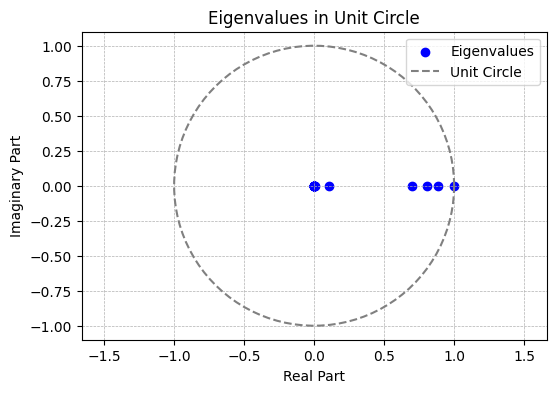

In [17]:
## Plot eigenvalues on unit circle
# Assuming evalues is a numpy array of complex numbers
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [18]:
efuns_real = np.real(efuns)
print(efuns_real.shape)
print(efuns_real)

(3000, 20)
[[ 1.09203366e+00 -6.35678272e-01 -9.98331238e-02 ...  7.84901464e-08
  -6.41219835e-07 -2.20889727e-06]
 [ 1.09188827e+00 -4.33483426e-01 -5.11661869e-02 ... -5.98203502e-09
   4.18989158e-08  3.57368915e-07]
 [ 1.09187683e+00 -4.12985334e-01 -4.63773387e-02 ... -9.07392180e-09
   6.42392236e-08  4.21712404e-07]
 ...
 [ 1.09189873e+00  1.86721763e-01 -1.71420843e-02 ... -3.60400453e-09
   2.19517886e-09  6.60544152e-07]
 [ 1.09192771e+00  1.67520266e-01 -1.41527745e-02 ... -2.30248225e-09
  -3.75562220e-10  4.74566688e-07]
 [ 1.09164360e+00  3.33665183e-01 -3.10878395e-02 ...  9.33113573e-09
   1.35745263e-09 -2.10589036e-06]]


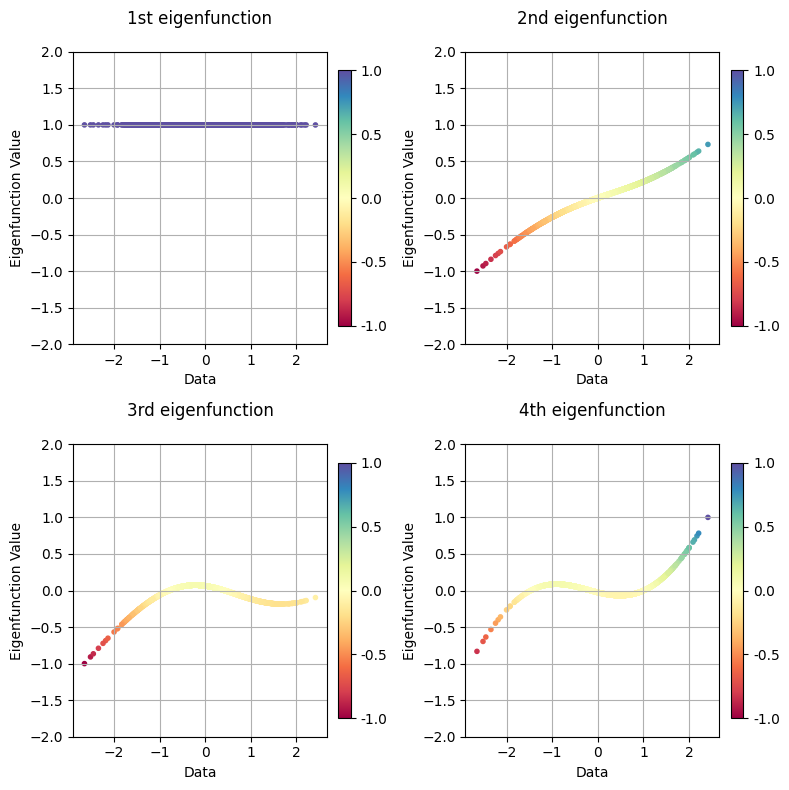

In [19]:
## Plot eigenfunctions
# Get the real part of eigenfunctions and normalize them
phi = np.real(efuns)

# Use the entire efuns instead of slicing
for i in range(len(evalues)):
    phi[:, i] = phi[:, i] / np.max(np.abs(phi[:, i]))

# Create a plot with 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
titles = ['1st eigenfunction', '2nd eigenfunction', '3rd eigenfunction', '4th eigenfunction']

# Determine global min and max values for the eigenfunctions for a uniform scale
vmin = np.min(phi)
vmax = np.max(phi)
cbar_ticks = np.linspace(vmin, vmax, 5)

# Flatten the 2D array of axes for easy iteration
axs_flat = axs.flatten()

for i, (ax, title) in enumerate(zip(axs_flat, titles)):
    scatter = ax.scatter(X, phi[:, i], c=phi[:, i], cmap='Spectral', marker='.', vmin=vmin, vmax=vmax)
    ax.set_title(title, pad=20)
    ax.set_xlabel('Data')
    ax.set_ylabel('Eigenfunction Value')
    ax.set_ylim(-2, 2)
    cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, ticks=cbar_ticks)
    cbar.set_ticklabels([f"{tick:.1f}" for tick in cbar_ticks])
    ax.grid()

plt.tight_layout()
plt.show()

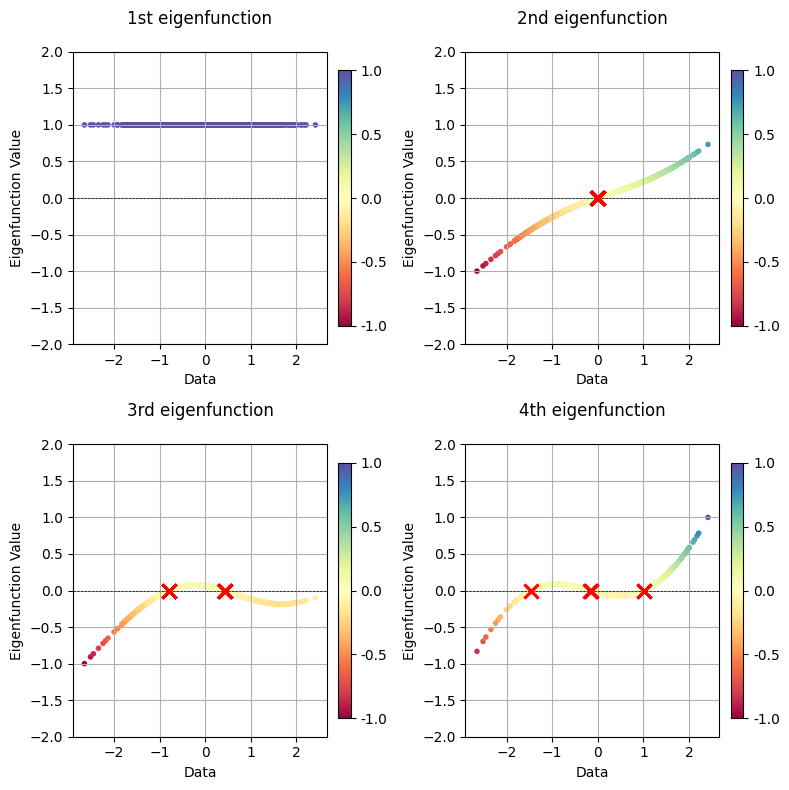

In [20]:
## Plot eigenfunctions with red cross at zero points
# Get the real part of eigenfunctions and normalize them
phi = np.real(efuns)

# Use the entire efuns instead of slicing
for i in range(len(evalues)):
    phi[:, i] = phi[:, i] / np.max(np.abs(phi[:, i]))

# Create a plot with 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
titles = ['1st eigenfunction', '2nd eigenfunction', '3rd eigenfunction', '4th eigenfunction']

# Determine global min and max values for the eigenfunctions for a uniform scale
vmin = np.min(phi)
vmax = np.max(phi)
cbar_ticks = np.linspace(vmin, vmax, 5)

# Flatten the 2D array of axes for easy iteration
axs_flat = axs.flatten()

for i, (ax, title) in enumerate(zip(axs_flat, titles)):
    scatter = ax.scatter(X, phi[:, i], c=phi[:, i], cmap='Spectral', marker='.', vmin=vmin, vmax=vmax)
    ax.set_title(title, pad=20)
    ax.set_xlabel('Data')
    ax.set_ylabel('Eigenfunction Value')
    ax.set_ylim(-2, 2)
    
    # Add x-axis
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

    # Find points where the function crosses the x-axis, add tolerance value
    tolerance = 1e-3
    zero_crossings = np.where(np.abs(phi[:, i]) < tolerance)[0]

    # Reduce the number of markers
    max_markers = 10
    if len(zero_crossings) > max_markers:
        zero_crossings = zero_crossings[::len(zero_crossings)//max_markers]

    # Add red markers at crossing points
    for crossing in zero_crossings:
        ax.plot(X[crossing], 0, 'rx', markersize=10, markeredgewidth=2)

    cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, ticks=cbar_ticks)
    cbar.set_ticklabels([f"{tick:.1f}" for tick in cbar_ticks])
    ax.grid()

plt.tight_layout()
plt.show()

In [ ]:
# # Get the real part of eigenfunctions and normalize them
# phi_train = np.real(efuns[:int(0.7*len_all), :])  # Slice efuns to match data_x_train
# for i in range(len(evalues)):
#     phi_train[:, i] = phi_train[:, i] / np.max(np.abs(phi_train[:, i]))

# # Create a plot
# fig, axs = plt.subplots(6, 1, figsize=(6, 30))
# titles = ['1st eigenfunction', '2nd eigenfunction', '3rd eigenfunction', '4th eigenfunction', '5th eigenfunction',
#           '6th eigenfunction']

# # Determine global min and max values for the eigenfunctions for a uniform scale
# vmin = np.min(phi_train)
# vmax = np.max(phi_train)
# cbar_ticks = np.linspace(vmin, vmax, 5)

# for i, title in enumerate(titles):
#     ax = axs[i]
#     scatter = ax.scatter(data_x_train, phi_train[:, i], c=phi_train[:, i], cmap='Spectral', marker='.', vmin=vmin, vmax=vmax)
#     ax.set_title(title, pad=20)
#     ax.set_xlabel('Data')
#     ax.set_ylabel('Eigenfunction Value')
#     ax.set_ylim(-2, 2)
#     cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.05, ticks=cbar_ticks)
#     cbar.set_ticklabels([f"{tick:.1f}" for tick in cbar_ticks])

# plt.tight_layout()
# plt.show()